In [1]:
from pearl.pearl_initial_formulation import *
from datastructures.graphutils import flatten_tree
from datastructures.api import (edges_no_param, addobj, addineq, OPT, SolverRef, merge, 
copy_dicts, setsolvefor)
from datastructures.graphutils import all_variables, all_edges
from datastructures.tearing import dir_graph, min_arc_set_assign
from datastructures.operators import reformulate
from datastructures.rendering import render_incidence
from datastructures.runpipeline import (model_to_problem, order_from_tree, 
    default_solver_options, mdao_workflow)
from datastructures.transformations import transform_components
from copy import deepcopy
import openmdao.api as om

/home/johan/miniconda3/envs/pyoptsparse/lib/python3.9/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)


In [3]:
run_optimal_structure = False

In [4]:
#nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges, tree = model.generate_formulation()
edges_nopar =  edges_no_param(model, edges)
outset_initial = {comp: var[0] for comp,var in edges[1].items()}

In [5]:
edges_for_solving = copy_dicts(edges_nopar)
eqnidxs = list(edges_for_solving[1].keys())
varidxs = all_variables(*edges_for_solving)
graph_edges_minassign = all_edges(*edges_for_solving)
edges_left_right = list(dir_graph(graph_edges_minassign, eqnidxs, {}))

In [6]:
not_input = [r'\omega_0', 'E_{move}', 'A_{33}', 'B_M', 'K_G', 'I', 'E_{recharge}', 'm_{struct}']
not_output = ['D_f', 'D_d', 'D_s', 't_s', 't_f', 't_d', 'P_{comms}', 'R'] #R
xsol,_ = min_arc_set_assign(edges_left_right, varidxs, eqnidxs, not_input, not_output)

Restricted license - for non-production use only - expires 2023-10-25


In [7]:
outset_opt = None
if run_optimal_structure:
    outset_opt = {right:left for left, right in edges_left_right if (left,right) in edges_left_right and xsol[left, right] > 0.5}

In [8]:
tree_for_reformulation = flatten_tree(tree, 'opt')
edges_minassign, tree_minassign = reformulate(edges, tree_for_reformulation, outset_initial, 
                                              outset_opt, root_solver_name='opt', mdf=False)
edges_minassign_noparam = edges_no_param(model, edges_minassign)

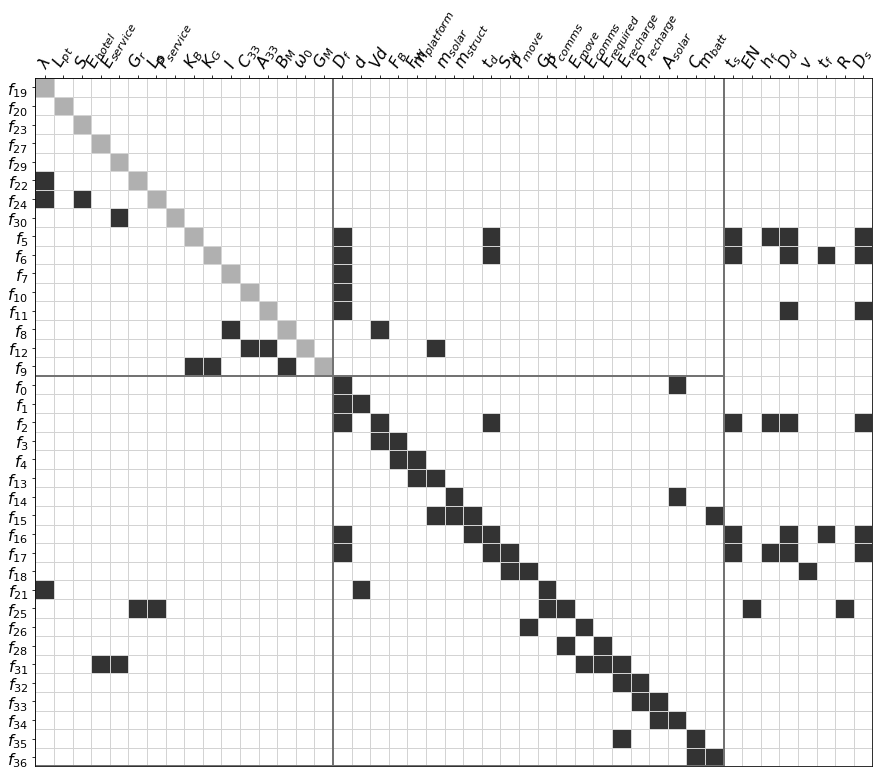

In [9]:
render_incidence(edges_minassign_noparam, tree_minassign, rawvarname=True, figsize=(15,15));

In [10]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [21]:
newcomps

[(('D_f', '\\alpha', 'A_{solar}'), 0, (None,), 'D_f - 1.12837916709551*(1/(1 - \\alpha))**0.5*Abs(A_{solar})**0.5'),
 (('D_f', '\\alpha', 'd'), 1, (None,), '-\\alpha*D_f + d'),
 (('h_f', 't_d', 'D_s', 'Vd', 'D_f', 'D_d', 't_s'), 2, (None,), '-0.785398163397448*D_d**2*t_d - 0.785398163397448*D_f**2*h_f - 0.785398163397448*D_s**2*t_s + Vd'),
 (('\\rho_w', 'Vd', 'F_B', 'g'), 3, (None,), '-\\rho_w*g*Vd + F_B'),
 (('F_B', 'F_W'), 4, (None,), '-F_B + F_W'),
 (('g', 'm_{platform}', 'F_W'), 13, (None,), 'g*m_{platform} - F_W'),
 (('m_{solar}', '\\eta_{solar}', 'A_{solar}'), 14, (None,), '-\\eta_{solar}*A_{solar} + m_{solar}'),
 (('m_{solar}', 'm_{platform}', 'm_{prop}', 'm_{comms}', 'm_{struct}', 'm_{batt}'), 15, (None,), 'm_{comms} + m_{prop} + m_{batt} - m_{platform} + m_{solar} + m_{struct}'),
 (('t_f', 'D_f', 'D_d', 'D_s', '\\rho_h', 't_d', '\\rho', 't_s', 'm_{struct}'), 16, (None,), '\\rho*D_f**2*t_f + \\rho*D_s**2*t_s + \\rho_h*D_d**2*t_d - 1.27323954473516*m_{struct}'),
 (('h_f', 't_d',

## Add optimization problem to model

In [11]:
opt = addsolver(m, name="opt", idbyname=True)
addobj(opt, mtot) # for optimization make sure to add OPT in model
addineq(opt, hf-0.9*tf)
addineq(opt, hf-0.9*tf)
addineq(opt, Ds-0.9*Df)
addineq(opt, 0.1-P_move)
addineq(opt, Ds-0.9*Dd)
## Initial structure:
addineq(opt, 50-Pcomms)
solvefor_init = [v, EN, hf, tf, ts, Ds, Dd]
varoptions_init = {v:[0], EN:[0.1,100], hf:[0], tf:[0.1,10], ts:[0.1,10], 
             Ds:[0.1,10], Dd:[0.1,10]}
varoptions_init.update({model.idmapping[elt]: [0] for elt in tree_minassign[2].keys()})
varoptions_init.update({td: [0.1,10]})
## Optimized structure:
solvefor_opt = [tf, ts, td, Ds, Dd, Df]
varoptions_opt = {tf:[0.1,10], ts:[0.1,10], td:[0.1,10], Ds:[0.1,10], Dd:[0.1,10], Df:[0.1,10]}

solvefor, varoptions = ((solvefor_init, varoptions_init), (solvefor_opt, varoptions_opt))[run_optimal_structure]
setsolvefor(opt, solvefor, varoptions)
model.solvers_options['opt'] = {'type': OPT, 'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}

In [12]:
#tree_minassign[2].keys()

In [13]:
formulation = model.generate_formulation()
edges_ma_opt, tree_ma_opt = merge(formulation, edges_minassign, 
                                  tree_minassign, copysolvers=False)

In [14]:
edges_ma_opt_nopar = edges_no_param(model, edges_ma_opt)

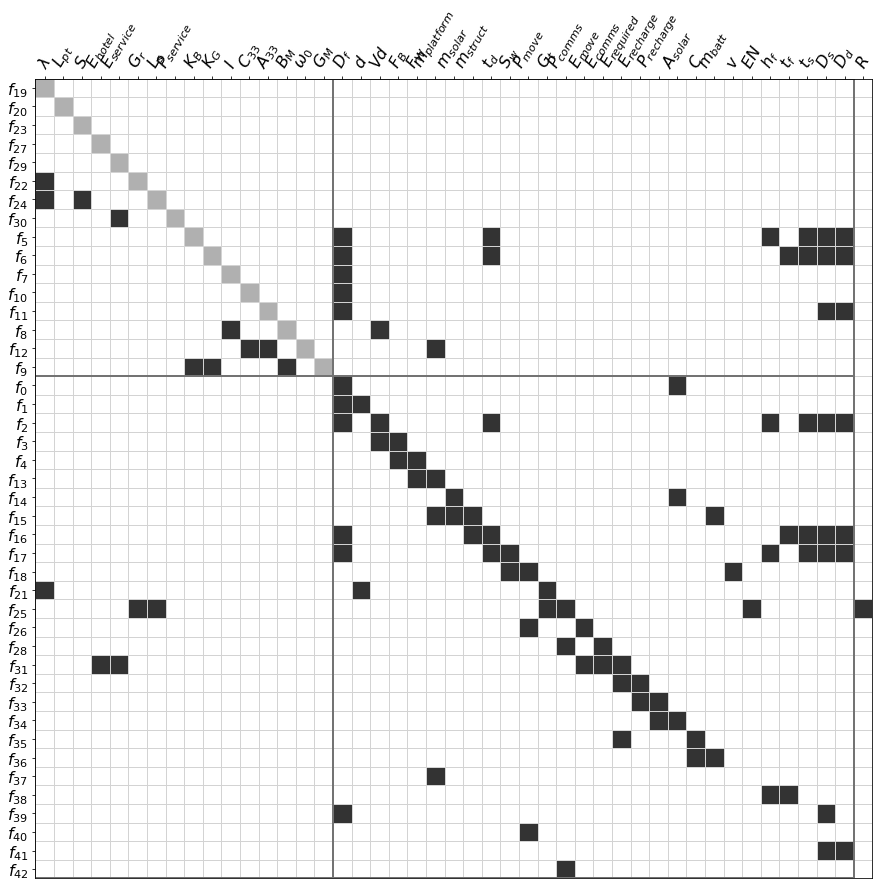

In [15]:
render_incidence(edges_ma_opt_nopar, tree_ma_opt, rawvarname=True, figsize=(15,15));

In [16]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, 
                        formulation=(edges_ma_opt, tree_ma_opt),
                        components=model.components+newcomps)

In [17]:
prob.set_val('P_comms', 50)

# Initial guesses

In [17]:
prob.set_val('alpha', 0.2)
prob.set_val('t_f',0.15)
prob.set_val('t_s',0.2)
prob.set_val('t_d',0.2)
prob.set_val('D_f', 3.713)
prob.set_val('D_s', 0.1)
prob.set_val('D_d', 1.)

In [18]:
import json
with open('x0init.json', 'r') as f:
    x0 = json.loads(f.read())
for var,val in x0.items():
    prob.set_val(var,val)

In [19]:
prob.run_model()

In [19]:
prob.run_driver()

/home/johan/miniconda3/envs/pyoptsparse/lib/python3.9/site-packages/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")
/home/johan/miniconda3/envs/pyoptsparse/lib/python3.9/site-packages/openmdao/core/total_jac.py:1567: DerivativesWarning:Constraints or objectives [('f42.neq42', inds=[0])] cannot be impacted by the design variables of the problem.




Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   19.2983
       User Objective Time :       0.3579
       User Sensitivity Time :    18.8814
       Interface Time :            0.0173
       Opt Solver Time:            0.0417
    Calls to Objective Function :      29
    Calls to Sens Function :           23


   Objectives
      Index  Name                 Value
          0  f37.obj37     5.853043E+02

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name        Type      Lower Bound            Value      Upper Bound     Status
          0  inp.t_f_0      c     1.000000E-01     9.999999E-02     1.000000E+01          l
          1  inp.t_s_0      c     1.000000E-01     1.000000E+01     1.000000E+01          u
          2  inp.t_d_0      c     1.000000E-01     9.999999E-02     1.000000E+01        

False

In [20]:
#prob.get_val('v')

In [22]:
ins_init = ['D_f', 'd', 'Vd', 'F_B', 'F_W', 'm_platform', 'm_solar', 'm_struct', 't_d', 'S_w', 'P_move', 'G_t', 'P_comms', 'E_move', 'E_comms', 'E_required', 'E_recharge', 'P_recharge', 'A_solar', 'C', 'm_batt', 'v', 'EN', 'h_f', 't_f', 't_s', 'D_s', 'D_d']
x0  = {elt:prob.get_val(elt)[0] for elt in ins_init}

In [23]:
import json
with open('x0init.json', 'w') as f:
    f.write(json.dumps(x0))

In [20]:
prob.list_problem_vars(desvar_opts=['lower','upper'], cons_opts=['lower', 'upper', 'equals']);

----------------
Design Variables
----------------
name        val               size  lower  upper  
----------  ----------------  ----  -----  ----- 
D_f         [1.98482595]      1     0.0    1e+30  
d           [0.39696519]      1     0.0    1e+30  
Vd          [0.5718096]       1     0.0    1e+30  
F_B         [5741.83528698]   1     0.0    1e+30  
F_W         [5741.83528698]   1     0.0    1e+30  
m_platform  [585.3043106]     1     0.0    1e+30  
m_solar     [24.75282237]     1     0.0    1e+30  
m_struct    [429.08005966]    1     0.0    1e+30  
t_d         [0.09999999]      1     0.1    10.0   
S_w         [9.77023399]      1     0.0    1e+30  
P_move      [0.09999999]      1     0.0    1e+30  
G_t         [46.0013032]      1     0.0    1e+30  
P_comms     [50.]             1     0.0    1e+30  
E_move      [9.99999901e-05]  1     0.0    1e+30  
E_comms     [50.]             1     0.0    1e+30  
E_required  [3.1501]          1     0.0    1e+30  
E_recharge  [3.1501]          1 